In [1]:
import numpy as np
import pandas
from numba import njit
import sys, glob
import urllib3
import h5py
import cdsapi, zipfile, os, time

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua4 as eua

import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

In [2]:
@njit#(cache=True)
def ctp(obs_val, plev, date_time):
    height = []
    counter = []
    tdunique=np.unique(date_time)
#     print(len(tdunique),tdunique[0]/365.25/86400)
    for i in range(len(tdunique)-1):
        tdi=np.searchsorted(date_time,[tdunique[i],tdunique[i+1]])
        temp_plev = plev[tdi[0]:tdi[1]]
        tplrange=np.searchsorted(temp_plev,[5000,40000])
        #print(temp_plev[tplrange[0]:tplrange[1]])
        temp_data = obs_val[tdi[0]+tplrange[0]:tdi[0]+tplrange[1]]
        if len(temp_data)>0:
            # looking for first temperature inversion from 300 hPa up
            found_plev=len(temp_data)-1
            for l in range(len(temp_data)-1,0,-1):
                if temp_data[l-1]>temp_data[l]:
                    found_plev=l
                    break
            ctpt=temp_data[found_plev]
            ctpp=temp_plev[tplrange[0]+found_plev]
            if not np.isnan(ctpt):
                height.append(ctpp)
                counter.append(tdunique[i])
    return height, counter



In [3]:
def plt_disp_tropoh(stat):
    print(stat)
    a = eua.CDMDataset(glob.glob('/users/staff/a1400070/scratch/converted_v8/*'+str(stat)+'*_CEUAS_merged_v1.nc')[0])
    df = a.to_dataframe(groups=['advanced_homogenisation', 'observations_table'], variables=['observed_variable', 'observation_value', 'date_time', 'z_coordinate', 'latitude_displacement'])

    df = df.dropna()
    df_t = df.loc[df.observed_variable == 126]

    out = {}
    out['height'], out['date'] = ctp(np.array(df_t.observation_value), np.array(df_t.z_coordinate), np.array(df_t.date_time))

    # out['tp_disp'] = []
    # out['max_disp'] = []
    out['disp'] = []
    for i in range(len(out['date'])):
        interm =  df_t.loc[df_t.date_time == out['date'][i]]
        out['disp'].append(interm.iloc[(interm['z_coordinate']-out['height'][i]).abs().argsort().iloc[0]]['latitude_displacement'])

    # #     out['tp_disp'].append(float(interm.loc[interm.z_coordinate == out['height'][i]].latitude_displacement))
    #     dispmin = np.nanmin(interm.latitude_displacement)
    #     dispmax = np.nanmax(interm.latitude_displacement)
    #     if np.absolute(dispmax) > np.absolute(dispmin):
    #         out['max_disp'].append(dispmax)
    #     else:
    #         out['max_disp'].append(dispmin)

    odf = pandas.DataFrame.from_dict(out)

    fig, ax1 = maplt.subplots(1, 1, figsize = (15,10))
    ax1.scatter(np.array(odf.disp), np.array(odf.height), color = 'blue',alpha = 0.3,)
    ax1.set_xlabel('Latitude Displacement at Tropopause[°]')
    ax1.set_ylabel('Tropopause Height [Pa]')
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.grid()
    maplt.show()
    maplt.close()

    
    maplt.style.use('seaborn-deep')
    south = []
    north = []
    bins = 30
    south.append(odf[(odf.disp < 0)].height)
    north.append(odf[(odf.disp > 0)].height)

    fig, ax1 = maplt.subplots(1, 1, figsize = (15,10))
    ax1.hist([north[0], south[0]], bins, label=['north', 'south'])
    ax1.legend(loc='best')
    ax1.set_ylabel('Number of Ascents')
    ax1.set_xlabel('Tropopause Height [Pa]')
    maplt.show()
    maplt.close()
    return

In [ ]:
era5 interp -> delta ctp zw disp und undisp ctp_temp und ctp_press

11035


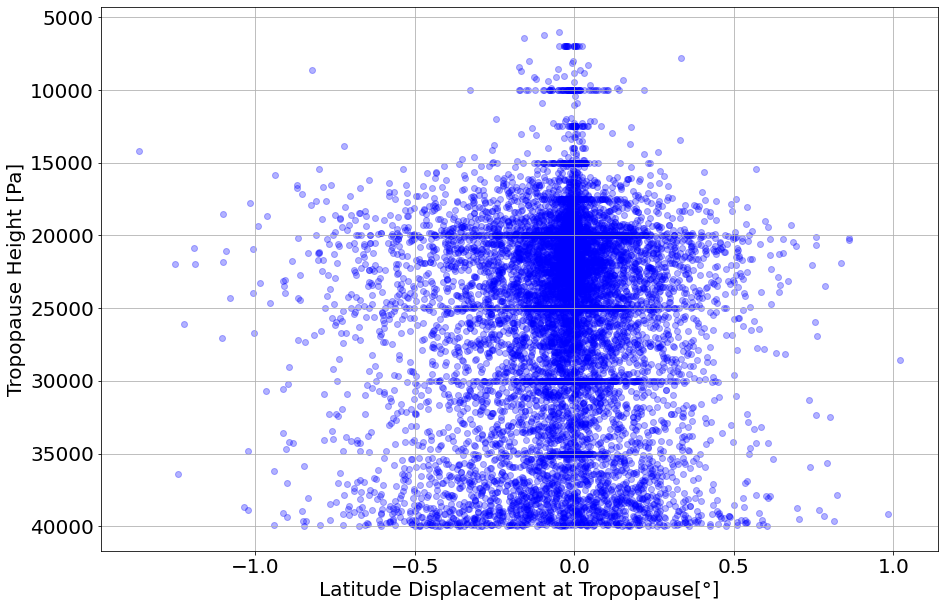

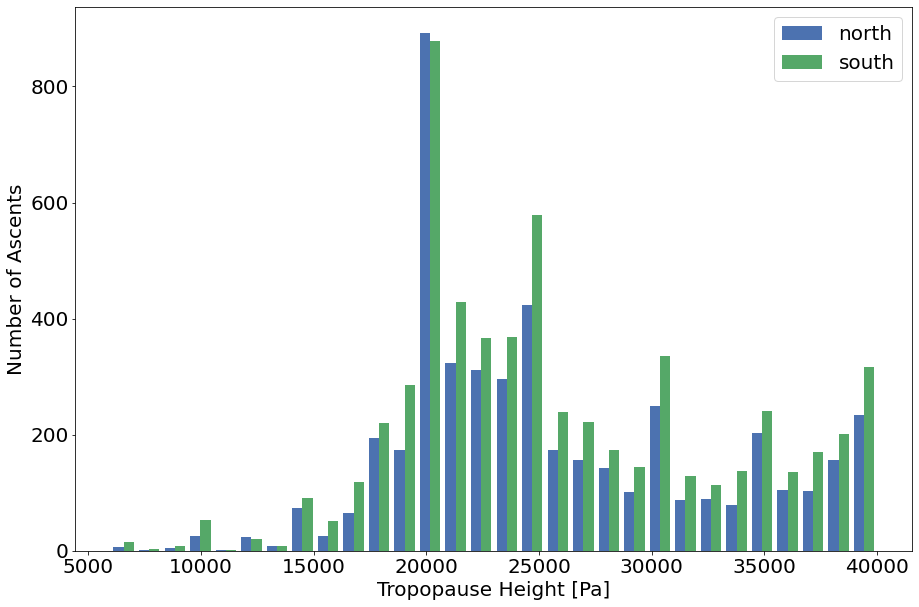

In [4]:
plt_disp_tropoh(11035)

10393


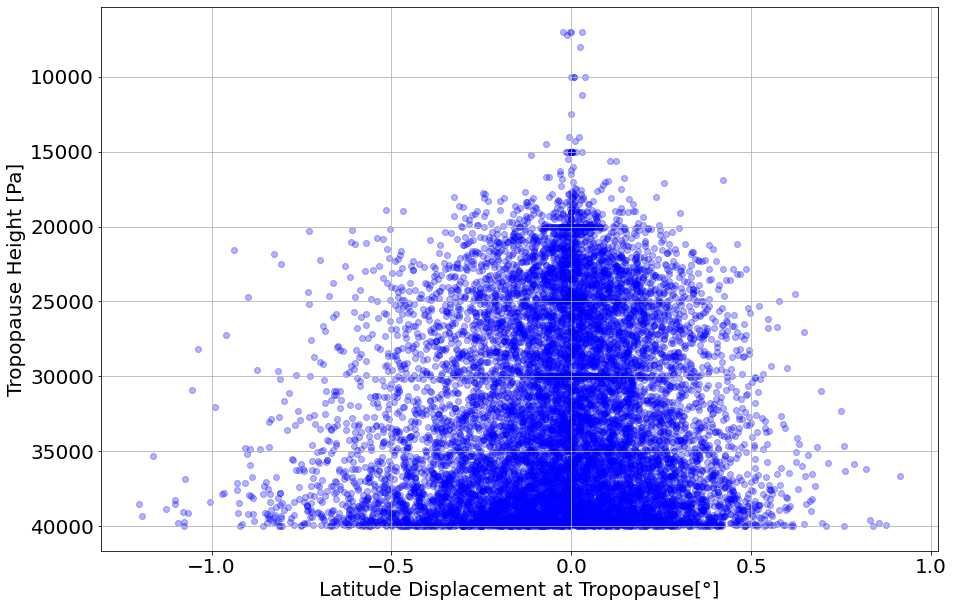

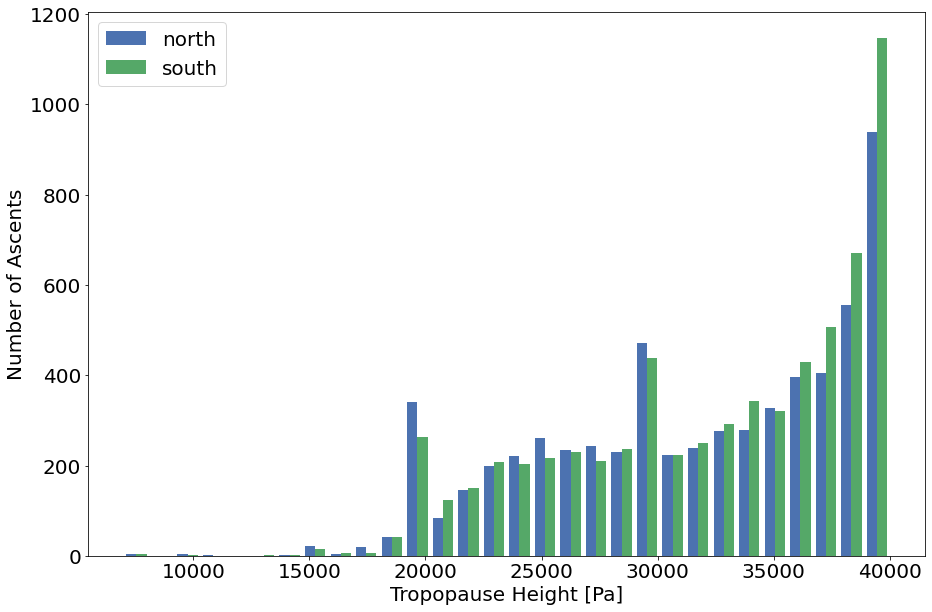

In [5]:
plt_disp_tropoh(10393)

06610


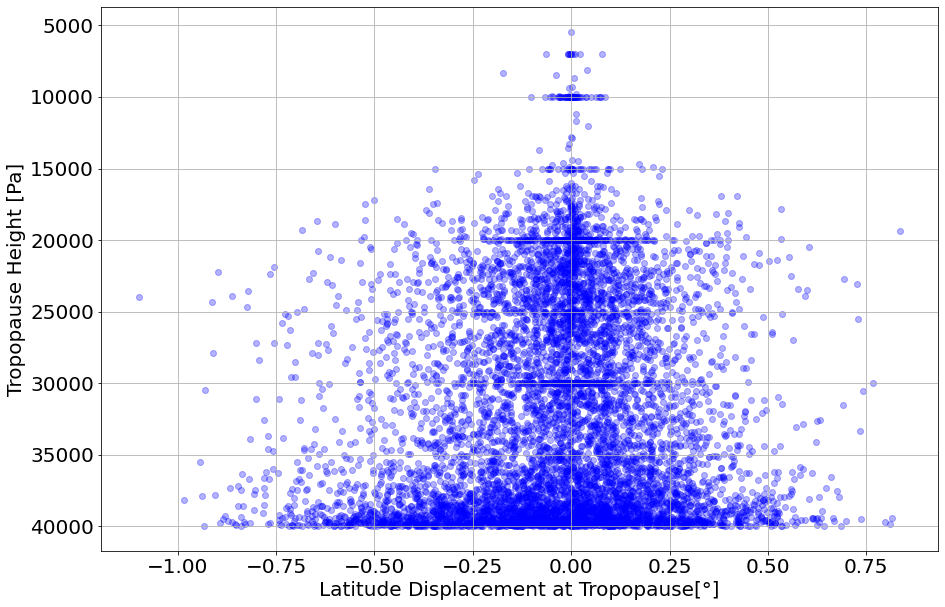

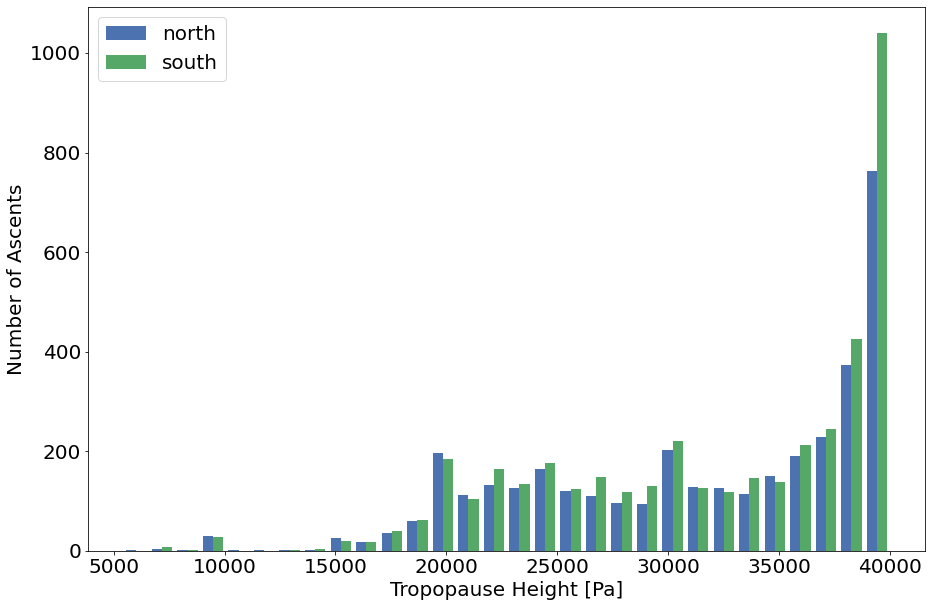

In [6]:
plt_disp_tropoh('06610')

70219


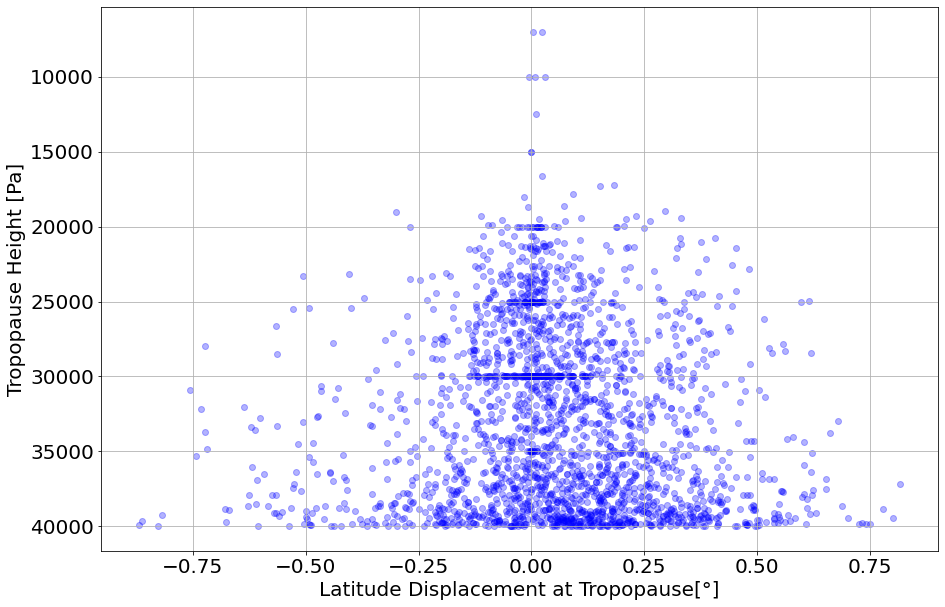

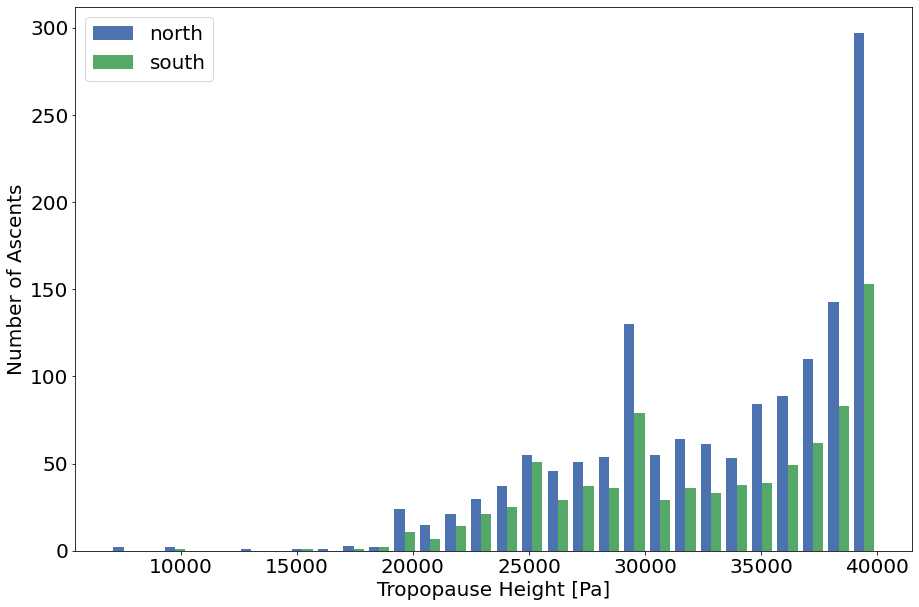

In [7]:
plt_disp_tropoh('70219')